In [1]:
import os
os.chdir('..')

# Data Cleaning And Transformation

## 1. Cleaning Steps
### 1.1 Identify Issues
* Identify missing values, duplicated and invalid data

### 1.2 Handle missing values
* Drop or fill null values
* Impute data

### 1.3 Standatize formats
* Convert date time
* Normalize categorical fields

### 1.4 Data Correction
* Correct data for each column

### 1.5 Deduplication Values
* Remove duplicated records

## 2. Tranformation Steps

### 2.1 Data Engineering
* Apply feature engineering

### 2.2 Store Data
* Store data in HDFS



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from src.config.config import (CUSTOMER_DATASET,
                               ORDER_DATASET,
                               ORDER_ITEMS_DATASET,
                               ORDER_PAYMENTS_DATASET,
                               ORDER_REVIEWS_DATASET,
                               PRODUCTS_DATASET,
                               SELLERS_DATASET,
                               GEOLOCATION_DATASET,
                               PRODUCT_TRANSLATIONS
                               )
hdfs_path = 'data/olist/'

spark = (SparkSession
            .builder
            .appName('olist')
            .getOrCreate())

spark

In [3]:
customer_dataset = spark.read.csv(hdfs_path + CUSTOMER_DATASET, header=True, inferSchema=True)
order_dataset = spark.read.csv(hdfs_path + ORDER_DATASET, header=True, inferSchema=True)
items_dataset = spark.read.csv(hdfs_path + ORDER_ITEMS_DATASET, header=True, inferSchema=True)
payments_dataset = spark.read.csv(hdfs_path + ORDER_PAYMENTS_DATASET, header=True, inferSchema=True)
reviews_dataset = spark.read.csv(hdfs_path + ORDER_REVIEWS_DATASET, header=True, inferSchema=True)
geolocation_dataset = spark.read.csv(hdfs_path + GEOLOCATION_DATASET, header=True, inferSchema=True)
products_dataset = spark.read.csv(hdfs_path + PRODUCTS_DATASET, header=True, inferSchema=True)
sellers_dataset = spark.read.csv(hdfs_path + SELLERS_DATASET, header=True, inferSchema=True)
translations = spark.read.csv(hdfs_path + PRODUCT_TRANSLATIONS, header=True, inferSchema=True)

### 1.1 Missing values

In [4]:
from pyspark.sql.functions import col

In [5]:
def missing_values(df):
    columns = df.columns
    report = {}
    for column in columns:
        n_missing = df.select([column]).filter(col(column).isNull()).count()
        report[column] = n_missing

    return report

In [6]:
customer_missing = missing_values(customer_dataset)
customer_missing

{'customer_id': 0,
 'customer_unique_id': 0,
 'customer_zip_code_prefix': 0,
 'customer_city': 0,
 'customer_state': 0}

In [7]:
order_missing=missing_values(order_dataset)
order_missing

{'order_id': 0,
 'customer_id': 0,
 'order_status': 0,
 'order_purchase_timestamp': 0,
 'order_approved_at': 160,
 'order_delivered_carrier_date': 1783,
 'order_delivered_customer_date': 2965,
 'order_estimated_delivery_date': 0}

In [8]:
items_missing=missing_values(items_dataset)
items_missing

{'order_id': 0,
 'order_item_id': 0,
 'product_id': 0,
 'seller_id': 0,
 'shipping_limit_date': 0,
 'price': 0,
 'freight_value': 0}

In [9]:
payments_missing=missing_values(payments_dataset)
payments_missing

{'order_id': 0,
 'payment_sequential': 0,
 'payment_type': 0,
 'payment_installments': 0,
 'payment_value': 0}

In [10]:
reviews_missing=missing_values(reviews_dataset)
reviews_missing

{'review_id': 1,
 'order_id': 2236,
 'review_score': 2380,
 'review_comment_title': 92157,
 'review_comment_message': 63079,
 'review_creation_date': 8764,
 'review_answer_timestamp': 8785}

In [11]:
geolocation_missing=missing_values(geolocation_dataset)
geolocation_missing


{'geolocation_zip_code_prefix': 0,
 'geolocation_lat': 0,
 'geolocation_lng': 0,
 'geolocation_city': 0,
 'geolocation_state': 0}

In [12]:
products_missing=missing_values(products_dataset)
products_missing

{'product_id': 0,
 'product_category_name': 610,
 'product_name_lenght': 610,
 'product_description_lenght': 610,
 'product_photos_qty': 610,
 'product_weight_g': 2,
 'product_length_cm': 2,
 'product_height_cm': 2,
 'product_width_cm': 2}

In [13]:
sellers_missing=missing_values(sellers_dataset)
sellers_missing

{'seller_id': 0,
 'seller_zip_code_prefix': 0,
 'seller_city': 0,
 'seller_state': 0}

In [14]:
translations_missing=missing_values(translations)
translations_missing


{'product_category_name': 0, 'product_category_name_english': 0}

In general, the datasets contain few missing values. The reviews dataset is the one which has more missing values

### Handle data issues

In [15]:
# Drop missing values
# drop missing values of the reviews_id in the reviews dataset
reviews_dataset=reviews_dataset.na.drop(subset=['review_id', 'order_id'])

# drop missing values of orders dataset in the ids fields which are pretty useless for analysis
# and may indicate problems on upstream processes
order_dataset = order_dataset.na.drop(subset=['order_id', 'customer_id', 'order_status'])

Fill Null values

In [16]:
# in orders dataset orders which are still not delivered havent order_delivered_date
# instead of just delete them we can just set a defaul value for those records
order_dataset = order_dataset.fillna({'order_delivered_carrier_date': '9999-12-31',
                                      'order_delivered_customer_date': '9999-12-31'})


In [17]:
order_dataset.filter(col('order_approved_at').isNull()).show()

+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|
+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+
|00b1cb0320190ca0d...|3532ba38a3fd24225...|    canceled|     2018-08-28 15:26:39|             NULL|         9999-12-31 00:00:00|          9999-12-31 00:00:00|          2018-09-12 00:00:00|
|ed3efbd3a87bea76c...|191984a8ba4cbb214...|    canceled|     2018-09-20 13:54:16|             NULL|         9999-12-31 00:00:00|          9999-12-31 00:00:00|          2018-10-17 00:00:00|
|df8282afe61008dc2...|aa797b187b5466bc6...|    canceled

Impute missing values
* Impute means using statistical/ml methods to fill null values using characteristics of the dataset instead of using arbitrary static values

In [18]:
# cast review score to int
from pyspark.sql.types import IntegerType

reviews_dataset = reviews_dataset.withColumn('review_score_int', col('review_score').cast(IntegerType()))

In [19]:
missing_values(reviews_dataset)

{'review_id': 0,
 'order_id': 0,
 'review_score': 144,
 'review_comment_title': 89922,
 'review_comment_message': 60843,
 'review_creation_date': 6528,
 'review_answer_timestamp': 6548,
 'review_score_int': 2698}

In [20]:
reviews_dataset.filter(col('review_score_int').isNull()).show()

+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------------------+----------------+
|           review_id|            order_id|        review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|review_score_int|
+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+-----------------------+----------------+
|     sem problemas."| 2018-03-23 00:00:00| 2018-04-01 00:27:51|                NULL|                  NULL|                NULL|                   NULL|            NULL|
|Faltou Controle R...| 2018-01-28 00:00:00| 2018-02-04 11:06:15|                NULL|                  NULL|                NULL|                   NULL|            NULL|
|Muito obrigada.... "| 2017-06-24 00:00:00| 2017-06-29 13:48:21|                NULL|                  NULL|                NULL|                

Indeed, there is some problem on some upstream process that changes values across columns

In [21]:
# drop those incorrect values
reviews_dataset=reviews_dataset.na.drop(subset=['review_score_int'])
reviews_dataset.show()

+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+----------------+
|           review_id|            order_id|review_score|review_comment_title|review_comment_message|review_creation_date|review_answer_timestamp|review_score_int|
+--------------------+--------------------+------------+--------------------+----------------------+--------------------+-----------------------+----------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|                NULL|                  NULL| 2018-01-18 00:00:00|    2018-01-18 21:46:59|               4|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|                NULL|                  NULL| 2018-03-10 00:00:00|    2018-03-11 03:05:13|               5|
|228ce5500dc1d8e02...|f9e4b658b201a9f2e...|           5|                NULL|                  NULL| 2018-02-17 00:00:00|    2018-02-18 14:36:24|               5|
|e64fb393e7b32834b...|

Imputing values

In [22]:
from pyspark.ml.feature import Imputer

input_prod_cols = ['product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']
output_prod_cols = [column +'_imp' for column in input_prod_cols]

imputer = Imputer(strategy='mean',
                  inputCols=input_prod_cols, 
                  outputCols= output_prod_cols)

products_dataset = imputer.fit(products_dataset).transform(products_dataset)

In [23]:
# remove old columns and rename the imputed columns
for col_old, col_new in zip(input_prod_cols, output_prod_cols):
    products_dataset= products_dataset.drop(col_old)
    products_dataset = products_dataset.withColumnRenamed(col_new, col_old)

In [24]:
missing_values(products_dataset)

{'product_id': 0,
 'product_category_name': 610,
 'product_name_lenght': 610,
 'product_description_lenght': 610,
 'product_photos_qty': 610,
 'product_weight_g': 0,
 'product_length_cm': 0,
 'product_height_cm': 0,
 'product_width_cm': 0}

### Standarizing Formats

Transform the value of some data across dataset to have a standarized data form.

In [25]:
geolocation_dataset.show()

+---------------------------+-------------------+-------------------+----------------+-----------------+
|geolocation_zip_code_prefix|    geolocation_lat|    geolocation_lng|geolocation_city|geolocation_state|
+---------------------------+-------------------+-------------------+----------------+-----------------+
|                       1037| -23.54562128115268| -46.63929204800168|       sao paulo|               SP|
|                       1046|-23.546081127035535| -46.64482029837157|       sao paulo|               SP|
|                       1046| -23.54612896641469| -46.64295148361138|       sao paulo|               SP|
|                       1041|  -23.5443921648681| -46.63949930627844|       sao paulo|               SP|
|                       1035|-23.541577961711493| -46.64160722329613|       sao paulo|               SP|
|                       1012|-23.547762303364266| -46.63536053788448|       são paulo|               SP|
|                       1047|-23.546273112412678| -46.6

In [26]:
cities = geolocation_dataset.select('geolocation_city').distinct()
cities.show()

# num of distinct cities
print(cities.count())


+--------------------+
|    geolocation_city|
+--------------------+
|sao bernardo do c...|
|           são paulo|
|            sãopaulo|
|             jundiaí|
|                  sp|
|           sao paulo|
|     taboão da serra|
|         carapicuiba|
|itapecerica da serra|
|               cotia|
|          embu guaçu|
|             barueri|
|pirapora do bom j...|
|      embu das artes|
|vargem grande pau...|
|              osasco|
|          embu guacu|
|                embu|
| santana de parnaiba|
|         carapicuíba|
+--------------------+
only showing top 20 rows

8011


In [27]:
# geolocation city coontain the same city with diffent typo sao paulo and são paulo
# standarize portuguse characters to basic form example (ã - >a)
from pyspark.sql.functions import regexp_replace

geolocation_dataset = (
    geolocation_dataset
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'ã', 'a'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'õ', 'o'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'ç', 's'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', '£', ''))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'á', 'a'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'é', 'e'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'í', 'i'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'ó', 'o'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'â', 'a'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'ê', 'e'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'ô', 'i'))
        .withColumn('geolocation_city', regexp_replace('geolocation_city', 'ú', 'u'))   
)

In [28]:
n_cities = geolocation_dataset.select('geolocation_city').distinct().count()
print('Number of distinct cities after normalization:', n_cities)

Number of distinct cities after normalization: 6272


In [29]:
geolocation_dataset.printSchema()

root
 |-- geolocation_zip_code_prefix: integer (nullable = true)
 |-- geolocation_lat: double (nullable = true)
 |-- geolocation_lng: double (nullable = true)
 |-- geolocation_city: string (nullable = true)
 |-- geolocation_state: string (nullable = true)



In [30]:
# cast geolocation zip code to string
from pyspark.sql.functions import StringType

geolocation_dataset = geolocation_dataset.withColumn('geolocation_zip_code_prefix', col('geolocation_zip_code_prefix').cast(StringType()))

In [31]:
# same to customer zipcode
customer_dataset = customer_dataset.withColumn('customer_zip_code_prefix', col('customer_zip_code_prefix').cast(StringType()))

### Remove Duplocate Records

In [32]:
print('rows before remove duplicates:', customer_dataset.count())

removed_customer = customer_dataset.dropDuplicates(['customer_id'])

print('rows after duplicates:', removed_customer.count())

rows before remove duplicates: 99441
rows after duplicates: 99441


### Data Transformation 

In [33]:
orders_detailed = (
    order_dataset
        .join(payments_dataset, 'order_id', 'left')
        .join(customer_dataset, 'customer_id', 'left')
        .join(items_dataset, 'order_id', 'left')
        )

In [34]:
orders_detailed.show()

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+------------------+------------+--------------------+-------------+--------------------+------------------------+--------------------+--------------+-------------+--------------------+--------------------+-------------------+-----+-------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|payment_sequential|payment_type|payment_installments|payment_value|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|order_item_id|          product_id|           seller_id|shipping_limit_date|price|freight_value|
+--------------------+--------------------+------------+------------------------+-------------------+---------------------------

In [35]:
orders_detailed.filter(col('price').isNull()).show()

+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+------------------+------------+--------------------+-------------+--------------------+------------------------+--------------------+--------------+-------------+----------+---------+-------------------+-----+-------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|payment_sequential|payment_type|payment_installments|payment_value|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|order_item_id|product_id|seller_id|shipping_limit_date|price|freight_value|
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+----------

In [36]:
missing_values(orders_detailed)

{'order_id': 0,
 'customer_id': 0,
 'order_status': 0,
 'order_purchase_timestamp': 0,
 'order_approved_at': 176,
 'order_delivered_carrier_date': 0,
 'order_delivered_customer_date': 0,
 'order_estimated_delivery_date': 0,
 'payment_sequential': 3,
 'payment_type': 3,
 'payment_installments': 3,
 'payment_value': 3,
 'customer_unique_id': 0,
 'customer_zip_code_prefix': 0,
 'customer_city': 0,
 'customer_state': 0,
 'order_item_id': 830,
 'product_id': 830,
 'seller_id': 830,
 'shipping_limit_date': 830,
 'price': 830,
 'freight_value': 830}

In [39]:
from pyspark.sql.functions import sum

# group per order to evaluate total value of the orders
orders_per_customers = orders_detailed.groupBy('order_id').agg(sum('payment_value').alias('total_order_value')).orderBy('total_order_value', ascending=False)
orders_per_customers.show()

+--------------------+------------------+
|            order_id| total_order_value|
+--------------------+------------------+
|03caa2c082116e1d3...|         109312.64|
|ab14fdcfbe524636d...| 45256.00000000001|
|1b15974a0141d54e3...|44048.000000000015|
|2cc9089445046817a...|          36489.24|
|e8fa22c3673b1dd17...|30185.999999999993|
|736e1922ae60d0d6a...|          29099.52|
|9aec4e1ae90b23c7b...|           22346.6|
|71dab1155600756af...|21874.049999999996|
|912343626f370ead5...|          19457.04|
|4412d97cb2093633a...|          19174.38|
|9f5054bd9a3c71702...|18667.000000000004|
|428a2f660dc84138d...|          18384.75|
|3a213fcdfe7d98be7...|          17786.88|
|f80549a97eb203e15...|           17671.0|
|cf4659487be50c0c3...|          17069.76|
|be382a9e1ed251281...|16313.600000000002|
|637617b3ffe9e2f7a...|14963.639999999998|
|c52c7fbe316b5b9d5...|14577.569999999998|
|f60ce04ff8060152c...|14401.000000000002|
|73c8ab38f07dc9438...|14196.280000000004|
+--------------------+------------

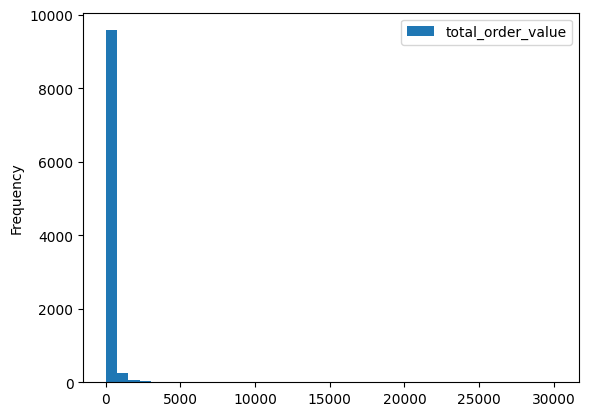

In [89]:
orders_per_customers.sample(fraction=0.1).toPandas().plot(kind='hist', bins=40);

In [49]:
quantiles_orders = orders_per_customers.approxQuantile('total_order_value', [0.25, 0.5, 0.75], relativeError=0.01)
quantiles_orders

[62.01, 111.6, 195.0]

In [ ]:
# summary calculates statistics but its computational expensive
orders_per_customers.select('total_order_value').summary().show()

+-------+------------------+
|summary| total_order_value|
+-------+------------------+
|  count|             99440|
|   mean|205.86008306520188|
| stddev| 619.1214548001797|
|    min|               0.0|
|    25%|             62.74|
|    50%|            109.62|
|    75%|            195.91|
|    max|         109312.64|
+-------+------------------+



In [58]:
orders_per_customers.count()

99441

In [75]:
# remove outliers from datasets
low_outlier, high_outlier = (
        orders_per_customers
            .select('total_order_value')
            .approxQuantile('total_order_value', [0.01, 0.99], relativeError=0.00)
        )

low_outlier, high_outlier

(22.38, 1645.82)

In [ ]:
orders_per_customers_out = (
        orders_per_customers
            .filter((col('total_order_value') <= low_outlier) | (col('total_order_value') >= high_outlier))
            )

orders_per_customers_out.show()

+--------------------+------------------+
|            order_id| total_order_value|
+--------------------+------------------+
|03caa2c082116e1d3...|         109312.64|
|ab14fdcfbe524636d...| 45256.00000000001|
|1b15974a0141d54e3...|44048.000000000015|
|2cc9089445046817a...|          36489.24|
|e8fa22c3673b1dd17...|30185.999999999993|
|736e1922ae60d0d6a...|          29099.52|
|9aec4e1ae90b23c7b...|           22346.6|
|71dab1155600756af...|21874.049999999996|
|912343626f370ead5...|          19457.04|
|4412d97cb2093633a...|          19174.38|
|9f5054bd9a3c71702...|18667.000000000004|
|428a2f660dc84138d...|          18384.75|
|3a213fcdfe7d98be7...|          17786.88|
|f80549a97eb203e15...|           17671.0|
|cf4659487be50c0c3...|          17069.76|
|be382a9e1ed251281...|16313.600000000002|
|637617b3ffe9e2f7a...|14963.639999999998|
|c52c7fbe316b5b9d5...|14577.569999999998|
|f60ce04ff8060152c...|14401.000000000002|
|73c8ab38f07dc9438...|14196.280000000004|
+--------------------+------------

In [80]:
orders_detailed_clean = orders_detailed.join(
    orders_per_customers_out, 'order_id', 'leftanti'
)

In [81]:
orders_detailed_clean.count()

113924

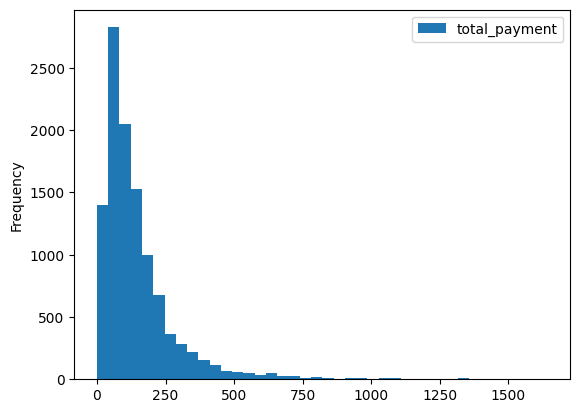

In [90]:
(
    orders_detailed_clean
        .sample(fraction=0.1)
        .groupBy('order_id')
        .agg(sum('payment_value').alias('total_payment'))
        .orderBy('total_payment', ascending=False)
        .select('total_payment')
        .toPandas()
        .plot(kind='hist', bins=40)
    );

### Write Data as Parquet


In [101]:
import os 
#hdfs
#!hadoop fs -mkdir /data/olist_processed

#local
os.mkdir(os.path.join('data', 'olist_processed'))

In [104]:
(
    orders_detailed_clean
        .write
        .option('compression', 'gzip')
        .mode('overwrite')
        .parquet(os.path.join('data', 'olist_processed', 'order_detailed_clean.parquet')))

In [105]:
orders_detailed_clean.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- payment_sequential: integer (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- payment_installments: integer (nullable = true)
 |-- payment_value: double (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable =

In [118]:
customer_dataset.write.mode('overwrite').saveAsTable('table')

In [120]:
spark.sql('select * from table').show()

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|f2a1d75b74d9ec748...|15ee900ec703c9a10...|                   68590|             jacunda|            PA|
|f15272fe9d0e2ae32...|11e74a9cbe1158d1c...|                   15056|sao jose do rio p...|            SP|
|7324ecb0ff143f561...|c6be127fa6e30c6f7...|                   13302|                 itu|            SP|
|7accf3d920f47c07f...|a7f1a6dc9ba06844b...|                   45638|             coaraci|            BA|
|3680a273ddb333253...|6cbfcc29787035834...|                   29700|            colatina|            ES|
|f18edbd308dd8784f...|ef6e328edc28262f4...|                   18055|            sorocaba|            SP|
|d7492c2b1d4bcba6c...|d681f09d6d055742a...|            